# Fake News Detector (French data)

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import string
import nltk

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.snowball import FrenchStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Dataset (train & test) acquisition

Data comes from Kaggle  
https://www.kaggle.com/hgilles06/frenchfakenewsdetector/code

In [36]:
dataset_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/frfakenews/datafake_train.csv',delimiter=';', encoding='utf-8')
dataset_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/frfakenews/datafake_test.csv',delimiter=';', encoding='utf-8')
dataset_train.head(5)

,media,post,fake
0,unknown,Sénatoriales : les résultats des élections.La ...,0
1,unknown,Live Spécial François Fillon\r\n27,1
2,unknown,Notre-Dame-des-Landes : « La décision prise pa...,0
3,unknown,"Chasse: silence, on tire.Avec l'autorisation d...",0
4,unknown,Payet lance un appel à l’OM : « S’il vous plaî...,1


In [37]:
def reformatDataset(df):
  df = df.drop(["media"], axis=1)
  df = df.rename(columns={'fake': 'label', 'post': 'text'})
  return df

dataset_train = reformatDataset(dataset_train)
dataset_test = reformatDataset(dataset_test)

In [38]:
dataset_train.head()

,text,label
0,Sénatoriales : les résultats des élections.La ...,0
1,Live Spécial François Fillon\r\n27,1
2,Notre-Dame-des-Landes : « La décision prise pa...,0
3,"Chasse: silence, on tire.Avec l'autorisation d...",0
4,Payet lance un appel à l’OM : « S’il vous plaî...,1


In [39]:
dataset_train.shape[0] + dataset_test.shape[0]

9494

## Work on text data first

### Remove punctuation & noise

In [40]:
def remove_punct(_str):
  _str = re.sub('['+string.punctuation+']', ' ', _str)
  _str = re.sub('[\r]', ' ', _str)
  _str = re.sub('[\n]', ' ', _str)
  _str = re.sub('[«»…"]', ' ', _str)
  _str = re.sub('[0-9]', ' ', _str)
  return _str

In [41]:
idx = 2
print("Before ->", dataset_train['text'][idx])
print("After ->", remove_punct(dataset_train['text'][idx]))

Before -> Notre-Dame-des-Landes : « La décision prise par l’exécutif est la moins risquée pour lui » 53.Cédric Pietralunga, journaliste au service politique du « Monde », a répondu aux questions des internautes après l’annonce de l’abandon du projet d’aéroport à Notre-Dame-des-Landes..partage facebook twitter
After -> Notre Dame des Landes     La décision prise par l’exécutif est la moins risquée pour lui      Cédric Pietralunga  journaliste au service politique du   Monde    a répondu aux questions des internautes après l’annonce de l’abandon du projet d’aéroport à Notre Dame des Landes  partage facebook twitter


In [8]:
dataset_train['text'] = dataset_train['text'].apply(remove_punct)
dataset_test['text'] = dataset_test['text'].apply(remove_punct)

### Remove stop words (french)

In [9]:
french_stopwords = set(stopwords.words('french'))
filtre_stopfr =  lambda text: [token for token in text if token.lower() not in french_stopwords]

In [10]:
filtre_stopfr(word_tokenize(dataset_train['text'][idx]))

['Comment',
 'Benoît',
 'Hamon',
 'prépare',
 'après',
 'ex',
 'candidat',
 'PS',
 'présidentielle',
 'quitte',
 'groupe',
 'PS',
 'région',
 'lance',
 'grande',
 'consultation',
 'nouveau',
 'mouvement']

In [11]:
[ txt for txt in filtre_stopfr(word_tokenize(dataset_train['text'][idx])) if len(txt)>2]

['Comment',
 'Benoît',
 'Hamon',
 'prépare',
 'après',
 'candidat',
 'présidentielle',
 'quitte',
 'groupe',
 'région',
 'lance',
 'grande',
 'consultation',
 'nouveau',
 'mouvement']

In [12]:
# Tokenize, remove stop words and remove the little words (less than 3 characters)
def remove_stop_words_fr(_str):
  return [ txt for txt in filtre_stopfr(word_tokenize(_str)) if len(txt)>2]

dataset_train['text'] = dataset_train['text'].apply(remove_stop_words_fr)
dataset_test['text'] = dataset_test['text'].apply(remove_stop_words_fr)

In [13]:
dataset_train

,text,label
0,"[Sénatoriales, résultats, élections, moitié, p...",0
1,"[Live, Spécial, François, Fillon]",1
2,"[Dame, Landes, décision, prise, exécutif, moin...",0
3,"[Chasse, silence, tire, autorisation, silencie...",0
4,"[Payet, lance, appel, plaît, laissez, peux, jo...",1
...,...,...
6640,"[DROIT, SUITE, Après, bousculades, Nutella, In...",0
6641,"[CORRUPTION, FÉMINISME, LANCEUR, ALERTE, MADAM...",1
6642,"[Barbier, Comment, Macron, sauvé, Terre, détou...",1
6643,"[Selon, Pierre, Gattaz, CGT, dispose, camps, e...",1


## Datasets creation

In [14]:
tokenizer = Tokenizer(num_words=50000, lower=None)
tokenizer.fit_on_texts(dataset_train['text'])
seq_train = tokenizer.texts_to_sequences(dataset_train['text'])
seq_test = tokenizer.texts_to_sequences(dataset_test['text'])

In [15]:
print("Nb of texts: " , tokenizer.document_count)
#print("Word indexes: " , tokenizer.word_index)
print("Word/token counts: " , len(tokenizer.word_counts))
nb_token = len(tokenizer.word_index)

Nb of texts:  6645
Word/token counts:  48712


In [16]:
ds_train = pad_sequences(seq_train)
train_seq_len = ds_train.shape[1]
ds_train.shape

(6645, 4031)

In [17]:
ds_test = pad_sequences(seq_test, maxlen=train_seq_len)
ds_test.shape

(2849, 4031)

In [18]:
y_train = dataset_train['label'].astype('int') 
y_test = dataset_test['label'].astype('int') 

## CNN Modeling

In [19]:
train_seq_len, nb_token

(4031, 48712)

In [20]:
ds_train

array([[    0,     0,     0, ...,  1032, 17017,  3273],
       [    0,     0,     0, ..., 17018,    49,   282],
       [    0,     0,     0, ...,     7,     9,     8],
       ...,
       [    0,     0,     0, ...,   477,  6655, 48706],
       [    0,     0,     0, ...,  8653,  7239, 17023],
       [    0,     0,     0, ...,     7,     9,     8]], dtype=int32)

In [21]:
ds_train.shape

(6645, 4031)

In [22]:
mon_cnn = tf.keras.Sequential()

mon_cnn.add(Input(shape=(train_seq_len,)))

mon_cnn.add(Embedding(nb_token + 1, 120))

mon_cnn.add(Conv1D(32, 3, activation='relu'))
mon_cnn.add(MaxPooling1D(3))

mon_cnn.add(Conv1D(64, 3, activation='relu'))
mon_cnn.add(MaxPooling1D(3))

mon_cnn.add(Conv1D(128, 3, activation='relu'))
mon_cnn.add(GlobalMaxPooling1D())

mon_cnn.add(Dense(1, activation='sigmoid'))

In [23]:
mon_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
mon_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4031, 120)         5845560   
_________________________________________________________________
conv1d (Conv1D)              (None, 4029, 32)          11552     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1343, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1341, 64)          6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 447, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 445, 128)          24704     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0

## Training

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)
mon_cnn.fit(x=ds_train, 
            y=y_train, 
            validation_data=(ds_test, y_test), 
            epochs=30
            ,callbacks=[early_stop]
            )

Epoch 1/30
208/208 [==============================] - 60s 145ms/step - loss: 0.4455 - accuracy: 0.7627 - val_loss: 0.0816 - val_accuracy: 0.9758
Epoch 2/30
208/208 [==============================] - 28s 136ms/step - loss: 0.0331 - accuracy: 0.9886 - val_loss: 0.0831 - val_accuracy: 0.9716
Epoch 3/30
208/208 [==============================] - 28s 135ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0931 - val_accuracy: 0.9677


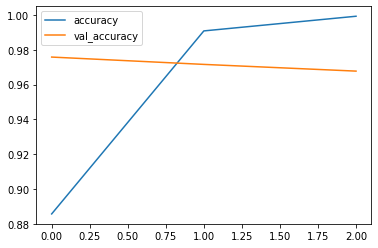

In [28]:
losses = pd.DataFrame(mon_cnn.history.history)
losses[['accuracy', 'val_accuracy']].plot()

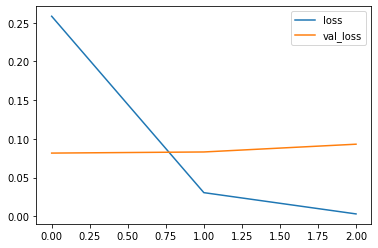

In [29]:
losses[['loss', 'val_loss']].plot()

In [30]:
from sklearn.metrics import precision_score, recall_score

y_test_pred = np.where(mon_cnn.predict(ds_test) > .5, 1, 0).reshape(1, -1)[0]
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_test_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_test_pred)))

Precision: 96.53%
Recall: 96.95%
